In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import time, os
from tqdm import tqdm
from sklearn import datasets

In [2]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, AffineConstantFlow
import nflib.coupling_flows as icf
import nflib.inn_flow as inn
import nflib.res_flow as irf

In [3]:
# np.random.seed(249)
# xx, y = datasets.make_circles(n_samples=300, factor=0.5, noise=0.05)
# x_ = np.random.randn(100, 2)*0.1
# xx = np.concatenate([xx, x_], axis=0)
# y = np.concatenate([y, np.ones(len(x_), dtype=int)*0])

In [4]:
np.random.seed(249) ## 148, 249

xxc, yc = datasets.make_circles(n_samples=265, factor=.5,
                                      noise=.07)
idx = yc==0
xxc = xxc[idx]
yc = yc[idx]

idx = (xxc[:,0]+xxc[:,1]<1)
xxc = xxc[idx]
yc = yc[idx]


xxm, ym = datasets.make_moons(n_samples=200, noise=.15)
xxm = xxm/2 - 0.2

xx = np.concatenate((xxm, xxc), axis=0)
y = np.concatenate((ym, yc+2), axis=0)

In [5]:
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([100, 100, 100]))

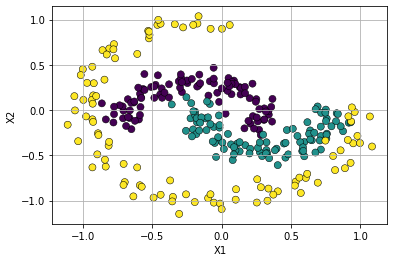

In [6]:
## MinMax Normalization
x1 = xx[:,0]
x2 = xx[:,1]
# x1 = (x1-x1.min())/(x1.max()-x1.min())
# x2 = (x2-x2.min())/(x2.max()-x2.min())
xx = np.column_stack((x1,x2))

xx = torch.Tensor(xx)
yy = torch.LongTensor(y.reshape(-1))

%matplotlib inline
plt.scatter(x1, x2, c=y, s=50, edgecolors='k', lw=0.5)

# (x1min, x1max) = -0.1, 1.1
# plt.xlim((x1min, x1max))
# plt.ylim((x1min, x1max))
plt.xlabel("X1")
plt.ylabel('X2')
plt.grid()

In [7]:
class ConnectedClassifier_Linear(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
#         self.inv_temp.requires_grad = False
        
        self.linear = nn.Linear(input_dim, num_sets)

#         init_val = torch.ones(num_sets, output_dim)/output_dim

        init_val = torch.randn(num_sets, output_dim)*0.1
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 0.5

        self.cls_weight = nn.Parameter(init_val)
        
        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
#         self.cls_weight.data = torch.abs(self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True))
        
        x = self.linear(x)
        if hard:
            x = torch.softmax(x*1e5, dim=1)
        else:
            x = torch.softmax(x*self.inv_temp, dim=1)
        self.cls_confidence = x
        
        c = torch.softmax(self.cls_weight, dim=1)
        c = self.cls_weight
        return x@c

In [8]:
class ConnectedClassifier_Distance(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        self.inv_temp.requires_grad = False
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        
#         init_val = torch.ones(num_sets, output_dim)/output_dim

        init_val = torch.randn(num_sets, output_dim)*0.1
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 0.5
        
        self.cls_weight = nn.Parameter(init_val.abs())

        self.cls_confidence = None
        
        self.move_loss = 0
        
        
    def forward(self, x, hard=False):
#         self.cls_weight.data.abs_()
#         self.cls_weight.data = self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True)
        
#         x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        
        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
        else:
            x = torch.softmax(-dists*self.inv_temp, dim=1)
        self.cls_confidence = x
        
        close_dist = dists.min(dim=1)[0]
        self.move_loss = nn.functional.smooth_l1_loss(close_dist, torch.zeros_like(close_dist))*0.1
#         self.move_loss = (close_dist**2).mean()*0.03
        
        c = torch.softmax(self.cls_weight, dim=1)
#         c = self.cls_weight
        return x@c

In [9]:
class ConnectedClassifier_Distance(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        self.inv_temp.requires_grad = False
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        
#         init_val = torch.ones(num_sets, output_dim)/output_dim

        init_val = torch.randn(num_sets, output_dim)*0.1
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 0.5
        
        self.cls_weight = nn.Parameter(init_val.abs())

        self.cls_confidence = None
        
        self.move_loss = 0
        
        
    def forward(self, x, hard=False):
#         self.cls_weight.data.abs_()
#         self.cls_weight.data = self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True)
        
#         x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        
        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
        else:
            x = torch.softmax(-dists*self.inv_temp, dim=1)
        self.cls_confidence = x
        
        close_dist = dists.min(dim=1)[0]
        self.move_loss = nn.functional.smooth_l1_loss(close_dist, torch.zeros_like(close_dist))*0.1
#         self.move_loss = (close_dist**2).mean()*0.03
        
        c = torch.softmax(self.cls_weight, dim=1)
#         c = self.cls_weight
        return x@c

In [41]:
class InverseDistanceWeighting_Classifier(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        self.inv_temp.requires_grad = False
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        
        init_val = torch.ones(num_sets, output_dim)/output_dim

        init_val = torch.randn(num_sets, output_dim)*0.1
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 0.5
        
        self.cls_weight = nn.Parameter(init_val.abs())
        self.cls_confidence = None
        
        self.move_loss = 0
        
        
    def forward(self, x, hard=False):
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        
        close_dist = dists.min(dim=1)[0]
        self.move_loss = nn.functional.smooth_l1_loss(close_dist, torch.zeros_like(close_dist))*0.1
        
        
        ### inverse distance weighting
        if hard:
            x = torch.zeros_like(dists)
            x[:, torch.argmax(-dists, dim=1)] = 1
#             x = torch.softmax(-dists*1e5, dim=1)
        else:
            w = 1/torch.clamp_min(dists, 0.1)
            x = w/torch.sum(w, dim=1, keepdim=True)
            
#         print(x[0])
#         print(x[0].sum())
        self.cls_confidence = x
        c = torch.softmax(self.cls_weight, dim=1)
        return x@c

In [42]:
clf = InverseDistanceWeighting_Classifier(2, 5, 3)
clf(torch.randn(1, 2))

tensor([[0.3591, 0.3438, 0.2971]], grad_fn=<MmBackward>)

In [43]:
# model = nn.Sequential(nn.Linear(2, 10, bias=False),
#                       nn.BatchNorm1d(10),
#                       nn.SELU(),
#                       nn.Linear(10, 2, bias=False),
#                       nn.BatchNorm1d(2),
#                       nn.SELU(),
#                      )

In [44]:
actf = irf.Swish
flows = [
    ActNorm(2),
    irf.ResidualFlow(2, [10], activation=actf),
    ActNorm(2),
    irf.ResidualFlow(2, [10], activation=actf),
    ActNorm(2),
        ]

model = SequentialFlow(flows)

In [45]:
model

SequentialFlow(
  (flows): ModuleList(
    (0): ActNorm()
    (1): ResidualFlow(
      (resblock): ModuleList(
        (0): Linear(in_features=2, out_features=10, bias=True)
        (1): Swish()
        (2): Linear(in_features=10, out_features=2, bias=True)
      )
    )
    (2): ActNorm()
    (3): ResidualFlow(
      (resblock): ModuleList(
        (0): Linear(in_features=2, out_features=10, bias=True)
        (1): Swish()
        (2): Linear(in_features=10, out_features=2, bias=True)
      )
    )
    (4): ActNorm()
  )
)

In [46]:
# classifier = ConnectedClassifier_Distance(2, 5, 3)
# classifier = nn.Sequential(nn.Linear(2,1), nn.Sigmoid())
classifier = InverseDistanceWeighting_Classifier(2, 5, 3)

## Model Train

In [47]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(list(model.parameters())+list(classifier.parameters()), lr=0.01)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  118


  0%|          | 0/4001 [00:00<?, ?it/s]

Epoch: 0 Loss: 1.1152242422103882 Accuracy: 0.4233333468437195


  2%|▏         | 91/4001 [00:00<00:28, 136.95it/s]

Epoch: 100 Loss: 0.9640082716941833 Accuracy: 0.6633333563804626


  5%|▍         | 197/4001 [00:01<00:25, 148.63it/s]

Epoch: 200 Loss: 0.8996432423591614 Accuracy: 0.7266666889190674


  7%|▋         | 285/4001 [00:02<00:26, 141.51it/s]

Epoch: 300 Loss: 0.867595911026001 Accuracy: 0.7566666603088379


 10%|▉         | 388/4001 [00:03<00:24, 145.00it/s]

Epoch: 400 Loss: 0.844347357749939 Accuracy: 0.7933333516120911


 12%|█▏        | 493/4001 [00:04<00:23, 146.42it/s]

Epoch: 500 Loss: 0.7905253767967224 Accuracy: 0.8999999761581421


 15%|█▍        | 597/4001 [00:05<00:23, 147.82it/s]

Epoch: 600 Loss: 0.7792695164680481 Accuracy: 0.8999999761581421


 17%|█▋        | 685/4001 [00:06<00:23, 142.31it/s]

Epoch: 700 Loss: 0.7731481790542603 Accuracy: 0.9166666865348816


 20%|█▉        | 791/4001 [00:07<00:21, 149.26it/s]

Epoch: 800 Loss: 0.7709675431251526 Accuracy: 0.9066666960716248


 22%|██▏       | 896/4001 [00:07<00:21, 147.86it/s]

Epoch: 900 Loss: 0.7688358426094055 Accuracy: 0.9100000262260437


 25%|██▍       | 985/4001 [00:08<00:21, 141.37it/s]

Epoch: 1000 Loss: 0.7669979333877563 Accuracy: 0.9100000262260437


 27%|██▋       | 1090/4001 [00:09<00:19, 147.76it/s]

Epoch: 1100 Loss: 0.7637786269187927 Accuracy: 0.9133333563804626


 30%|██▉       | 1196/4001 [00:10<00:18, 149.06it/s]

Epoch: 1200 Loss: 0.75847327709198 Accuracy: 0.9166666865348816


 32%|███▏      | 1284/4001 [00:11<00:19, 138.31it/s]

Epoch: 1300 Loss: 0.7563649415969849 Accuracy: 0.9066666960716248


 35%|███▍      | 1389/4001 [00:12<00:17, 148.22it/s]

Epoch: 1400 Loss: 0.7455848455429077 Accuracy: 0.9166666865348816


 37%|███▋      | 1497/4001 [00:13<00:16, 155.13it/s]

Epoch: 1500 Loss: 0.7427391409873962 Accuracy: 0.9166666865348816


 40%|███▉      | 1586/4001 [00:14<00:17, 141.10it/s]

Epoch: 1600 Loss: 0.7394475936889648 Accuracy: 0.9066666960716248


 42%|████▏     | 1692/4001 [00:14<00:14, 154.03it/s]

Epoch: 1700 Loss: 0.7346269488334656 Accuracy: 0.9100000262260437


 45%|████▍     | 1791/4001 [00:15<00:15, 141.53it/s]

Epoch: 1800 Loss: 0.7314295768737793 Accuracy: 0.9133333563804626


 47%|████▋     | 1896/4001 [00:16<00:14, 147.91it/s]

Epoch: 1900 Loss: 0.7197245359420776 Accuracy: 0.9233333468437195


 50%|████▉     | 1998/4001 [00:17<00:14, 139.79it/s]

Epoch: 2000 Loss: 0.7112815976142883 Accuracy: 0.9333333373069763


 52%|█████▏    | 2086/4001 [00:18<00:13, 140.25it/s]

Epoch: 2100 Loss: 0.7108203768730164 Accuracy: 0.9233333468437195


 55%|█████▍    | 2187/4001 [00:19<00:12, 141.46it/s]

Epoch: 2200 Loss: 0.7006754279136658 Accuracy: 0.9266666769981384


 57%|█████▋    | 2284/4001 [00:20<00:12, 138.15it/s]

Epoch: 2300 Loss: 0.7087852358818054 Accuracy: 0.9233333468437195


 60%|█████▉    | 2385/4001 [00:21<00:11, 141.26it/s]

Epoch: 2400 Loss: 0.6960210204124451 Accuracy: 0.9333333373069763


 62%|██████▏   | 2487/4001 [00:22<00:10, 147.14it/s]

Epoch: 2500 Loss: 0.6960646510124207 Accuracy: 0.9233333468437195


 65%|██████▍   | 2587/4001 [00:22<00:09, 143.12it/s]

Epoch: 2600 Loss: 0.6918159127235413 Accuracy: 0.9300000071525574


 67%|██████▋   | 2691/4001 [00:23<00:08, 151.89it/s]

Epoch: 2700 Loss: 0.683981716632843 Accuracy: 0.9300000071525574


 70%|██████▉   | 2797/4001 [00:24<00:07, 152.45it/s]

Epoch: 2800 Loss: 0.6804488897323608 Accuracy: 0.9366666674613953


 72%|███████▏  | 2900/4001 [00:25<00:07, 141.60it/s]

Epoch: 2900 Loss: 0.6797070503234863 Accuracy: 0.9433333277702332


 75%|███████▍  | 2986/4001 [00:26<00:07, 137.33it/s]

Epoch: 3000 Loss: 0.6792135834693909 Accuracy: 0.9333333373069763


 77%|███████▋  | 3090/4001 [00:27<00:06, 146.17it/s]

Epoch: 3100 Loss: 0.6763949394226074 Accuracy: 0.9433333277702332


 80%|███████▉  | 3196/4001 [00:28<00:05, 148.13it/s]

Epoch: 3200 Loss: 0.6735915541648865 Accuracy: 0.9399999976158142


 82%|████████▏ | 3298/4001 [00:29<00:05, 136.23it/s]

Epoch: 3300 Loss: 0.6750879287719727 Accuracy: 0.9433333277702332


 85%|████████▍ | 3387/4001 [00:30<00:05, 119.34it/s]

Epoch: 3400 Loss: 0.6770564913749695 Accuracy: 0.9466666579246521


 87%|████████▋ | 3493/4001 [00:31<00:03, 127.70it/s]

Epoch: 3500 Loss: 0.6709831953048706 Accuracy: 0.9466666579246521


 90%|████████▉ | 3588/4001 [00:32<00:03, 131.24it/s]

Epoch: 3600 Loss: 0.6695514917373657 Accuracy: 0.9433333277702332


 92%|█████████▏| 3700/4001 [00:33<00:02, 138.44it/s]

Epoch: 3700 Loss: 0.66841721534729 Accuracy: 0.9466666579246521


 95%|█████████▍| 3799/4001 [00:34<00:01, 106.76it/s]

Epoch: 3800 Loss: 0.6677539348602295 Accuracy: 0.9433333277702332


 97%|█████████▋| 3897/4001 [00:35<00:00, 132.78it/s]

Epoch: 3900 Loss: 0.6660683155059814 Accuracy: 0.9433333277702332


100%|█████████▉| 3985/4001 [00:36<00:00, 118.67it/s]

Epoch: 4000 Loss: 0.6657169461250305 Accuracy: 0.9433333277702332


100%|██████████| 4001/4001 [00:36<00:00, 109.14it/s]


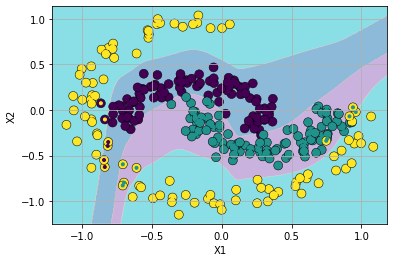

In [48]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca()#projection='3d')

model.train()
losses = []
NUM = 512

### for plotting in 2d grid
ng = 400
_a,_b,_c,_d = x1.min()-0.1, x1.max()+0.1, x2.min()-0.1, x2.max()+0.1
xg, yg = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xg, yg = np.meshgrid(xg, yg)
xyg = np.stack([xg.reshape(-1), yg.reshape(-1)], axis=-1)
xyg = torch.Tensor(xyg)

for epoch in tqdm(range(1000*4+1)):
    optimizer.zero_grad()
    
    z = model(xx)
    yout = classifier(z)
    
    loss = criterion(yout, yy) + classifier.move_loss
    loss.backward()
    optimizer.step()
        
    if epoch%100 == 0:
        acc = (yout.data.argmax(dim=1) == yy)
        acc = float(acc.type(torch.float32).mean())
        losses.append(float(loss))
        print(f"Epoch: {epoch} Loss: {losses[-1]} Accuracy: {acc}")

        ax.clear()
        model.eval()
        with torch.no_grad():
            z = model(xx)
            yout = classifier(z)
            yout = yout.argmax(dim=1).numpy()
            yout_img = classifier(model(xyg))
        model.train()
        
        out = yout_img.data.argmax(dim=1).numpy()
        cf = ax.contourf(xg, yg, out.reshape(xg.shape),# v,
                         alpha=0.5, cmap=matplotlib.cm.tab10, antialiased=True)
        ax.grid()

        ax.scatter(x1, x2, c=yy.numpy(), s=80, edgecolors='k', lw=0.5)
        ax.scatter(x1, x2, c=yout.reshape(-1), marker='.')
            
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        
        fig.canvas.draw()
        plt.pause(0.01)


In [49]:
classifier.inv_temp

Parameter containing:
tensor([1.])

In [50]:
inv_centers = model.inverse(classifier.centers.data).data
inv_centers

tensor([[ -2.0949, -12.0344],
        [ -8.5803, -67.5388],
        [  6.7911,   6.2341],
        [-10.7326, -85.5308],
        [ -3.2427, -22.9826]])

In [51]:
model(inv_centers)

tensor([[-1.0810,  0.2068],
        [ 4.8876,  0.1456],
        [-7.5878,  0.4006],
        [ 3.6868,  0.1608],
        [ 7.6014,  0.1008]], grad_fn=<AddBackward0>)

In [52]:
classifier.centers

Parameter containing:
tensor([[-1.0810,  0.2068],
        [ 4.8866,  0.1457],
        [-7.5879,  0.4006],
        [ 3.6857,  0.1608],
        [ 7.6014,  0.1008]], requires_grad=True)

### Plot the classifiers

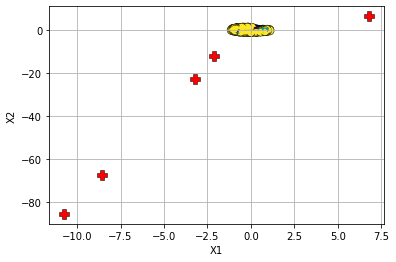

In [53]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca()

model.eval()
with torch.no_grad():
    z = model(xx)
    yout = classifier(z)
    _ = classifier(model(xyg))
model.train()

out = classifier.cls_confidence.argmax(dim=1).numpy()
cf = ax.contourf(xg, yg, out.reshape(xg.shape),# v,
                 alpha=0.9, cmap="tab10", antialiased=True)
ax.grid()

ax.scatter(x1, x2, c=yy.numpy(), s=80, edgecolors='k', lw=0.5)
ax.scatter(x1, x2, c=yout.argmax(dim=1).numpy(), marker='.')

ax.scatter(inv_centers[:,0], inv_centers[:,1], color="r", s=100, edgecolors='k', marker="P", lw=0.5)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.show()

### Plot the classifier in z-space along with inputs

In [54]:
model.eval()
with torch.no_grad():
    z = model(xx)
    ### get the range of z value 
    zmin = z.min(dim=0)[0]*1.1
    zmax = z.max(dim=0)[0]*1.1
    
    xyg_ = (xyg+1)/2 * (zmax-zmin) + zmin
    _ = classifier(model(xyg_))
# model.train()

In [55]:
zmin, zmax

(tensor([-8.6634,  0.0559]), tensor([8.5456, 0.5675]))

In [56]:
xyg_.min(dim=0)[0]

tensor([-1.0471e+01, -7.4235e-03])

In [57]:
xyg_.max(dim=0)[0]

tensor([10.1319,  0.6026])

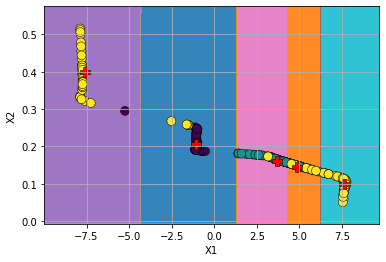

In [58]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca()

model.eval(); classifier.eval()
with torch.no_grad():
    z = model(xx)
    ### get the range of z value 
    zmin = z.min(dim=0)[0]*1.05
    zmax = z.max(dim=0)[0]*1.05
    
    xyg_ = (xyg+1)/2 * (zmax-zmin) + zmin
    _ = classifier(xyg_)
model.train(); classifier.train()

out = classifier.cls_confidence.argmax(dim=1).numpy()

cf = ax.contourf(xyg_[:,0].reshape(xg.shape),
                 xyg_[:,1].reshape(yg.shape),
                 out.reshape(xg.shape),# v,
                 alpha=0.9, cmap="tab10", antialiased=True)
ax.grid()

ax.scatter(z[:,0], z[:,1], c=yy.numpy(), s=80, edgecolors='k', lw=0.5)
# ax.scatter(x1, x2, c=yout.argmax(dim=1).numpy(), marker='.')

ax.scatter(classifier.centers.data[:,0], classifier.centers.data[:,1], color="r", s=100, edgecolors='k', marker="P", lw=0.5)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.show()

### Plot the distance from winning classifier, in z space

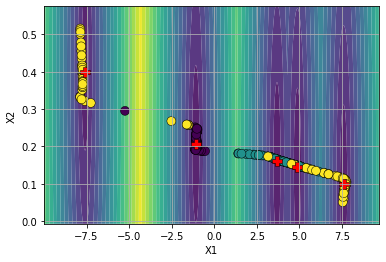

In [59]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca()

model.eval(); classifier.eval()
with torch.no_grad():
    z = model(xx)
    ### get the range of z value 
    zmin = z.min(dim=0)[0]*1.05
    zmax = z.max(dim=0)[0]*1.05
    
    xyg_ = (xyg+1)/2 * (zmax-zmin) + zmin
    _ = classifier(xyg_)
    
    dists = torch.cdist(xyg_, classifier.centers)
    dists = dists/np.sqrt(classifier.input_dim)
model.train(); classifier.train()

out = dists.min(dim=1)[0].numpy()

cf = ax.contourf(xyg_[:,0].reshape(xg.shape),
                 xyg_[:,1].reshape(yg.shape),
                 out.reshape(xg.shape),# v,
                 levels=20,
                 alpha=0.9, cmap="viridis", antialiased=True)
ax.grid()

ax.scatter(z[:,0], z[:,1], c=yy.numpy(), s=80, edgecolors='k', lw=0.5)
# ax.scatter(x1, x2, c=yout.argmax(dim=1).numpy(), marker='.')

ax.scatter(classifier.centers.data[:,0], classifier.centers.data[:,1], color="r", s=100, edgecolors='k', marker="P", lw=0.5)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.show()

### Distance from winning class in x-space

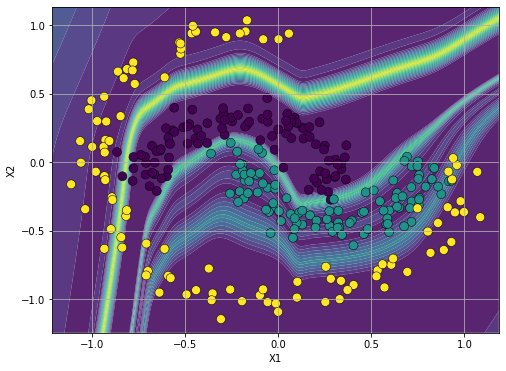

In [60]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
ax = fig.gca()

model.eval(); classifier.eval()
with torch.no_grad():
    xyg_ = model(xyg)
    _ = classifier(xyg_)
    
    dists = torch.cdist(xyg_, classifier.centers)
    dists = dists/np.sqrt(classifier.input_dim)
model.train(); classifier.train()

out = dists.min(dim=1)[0].numpy()

cf = ax.contourf(xyg[:,0].reshape(xg.shape),
                 xyg[:,1].reshape(yg.shape),
                 out.reshape(xg.shape),# v,
                 levels=20,
                 alpha=0.9, cmap="viridis", antialiased=True)
ax.grid()

ax.scatter(x1, x2, c=yy.numpy(), s=80, edgecolors='k', lw=0.5)
# ax.scatter(inv_centers[:,0], inv_centers[:,1], color="r", s=80, edgecolors='k', lw=0.5)
# ax.scatter(x1, x2, c=yout.argmax(dim=1).numpy(), marker='.')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.show()

In [27]:
with torch.no_grad():
    z = model(xyg)
    _ = classifier(z)
    
    dists = torch.cdist(z, classifier.centers)
    dists = dists/np.sqrt(classifier.input_dim)

In [28]:
minval, indx = dists.min(dim=1)

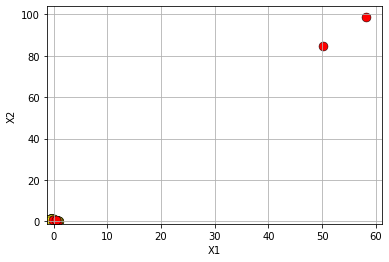

In [29]:

%matplotlib inline
fig = plt.figure()
ax = fig.gca()

model.eval()
with torch.no_grad():
    z = model(xyg)
    _ = classifier(z)
    
    dists = torch.cdist(z, classifier.centers)
    dists = dists/np.sqrt(classifier.input_dim)
    
model.train()
# out = classifier.cls_confidence.argmax(dim=1).numpy()
out = dists.min(dim=1)[0]

cf = ax.contourf(xg, yg, out.reshape(xg.shape),# v,
                 alpha=0.9, cmap="bwr", antialiased=True)
ax.grid()

ax.scatter(x1, x2, c=yy.numpy(), s=80, edgecolors='k', lw=0.5)
# ax.scatter(x1, x2, c=yout.argmax(dim=1).numpy(), marker='.')

ax.scatter(inv_centers[:,0], inv_centers[:,1], color="r", s=80, edgecolors='k', lw=0.5)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.show()

In [30]:
dists.min(dim=1)[0]

tensor([0.0693, 0.0687, 0.0682,  ..., 0.8170, 0.8597, 0.9023])